In [1]:
import os, pickle
import pandas as pd
import numpy as np
# 
import matplotlib.pyplot as plt
from IPython.display import display
# 
from sklearn import metrics
from sklearn.model_selection import train_test_split
# 
import xgboost as xgb
from xgboost import plot_importance

# some settings for displaying Pandas results
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.precision', 4)
pd.set_option('display.max_colwidth', -1)

# Load combined features with label (option 1)

In [2]:
%%time
# specified features set for joining
ls_feat_file = [
    'baseline.pkl.bz2',
    'baseline_extend.pkl.bz2',
]

# use first features for base joined
feat_path = os.path.join("../04_feature_engineering/features", ls_feat_file[0])
pdf_combined = pd.read_pickle(feat_path, compression="bz2")

# join next features set
for fname in ls_feat_file[1:]:
    feat_path = os.path.join("../04_feature_engineering/features", fname)
    pdf_feat = pd.read_pickle(feat_path, compression="bz2")
    print(fname, pdf_feat.shape)
    
    # add table prefix
    tbl_prefix = fname.split(".")[0]
    rename_col = {cname: "{}_{}".format(tbl_prefix, cname) for cname in pdf_feat.columns if cname != "SK_ID_CURR"}
    pdf_feat.rename(columns=rename_col, inplace=True)
    
    # join
    pdf_combined = pdf_combined.merge(pdf_feat, on="SK_ID_CURR", how="left")

print("rows, columns", pdf_combined.shape)
ls_features = [feat for feat in pdf_combined.columns if feat not in ["SK_ID_CURR"]]
display(pdf_combined.head())

baseline_extend.pkl.bz2 (356255, 77)
rows, columns (356255, 154)


,SK_ID_CURR,NAME_INCOME_TYPE_Working,is_REGION_RATING_CLIENT_W_CITY,is_REGION_RATING_CLIENT,is_CODE_GENDER,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Secondary___secondary_special,is_REG_CITY_NOT_WORK_CITY,is_FLAG_DOCUMENT_3,HOUSETYPE_MODE_block_of_flats,NAME_INCOME_TYPE_Pensioner,ORGANIZATION_TYPE_XNA,is_FLAG_EMP_PHONE,OCCUPATION_TYPE_Laborers,WALLSMATERIAL_MODE_Panel,is_LIVE_CITY_NOT_WORK_CITY,NAME_FAMILY_STATUS_Married,is_FLAG_WORK_PHONE,is_FLAG_PHONE,is_FLAG_OWN_CAR,ORGANIZATION_TYPE_Self_employed,ORGANIZATION_TYPE_Business_Entity_Type_3,NAME_FAMILY_STATUS_Single___not_married,FONDKAPREMONT_MODE_reg_oper_account,is_NAME_CONTRACT_TYPE,NAME_HOUSING_TYPE_House___apartment,is_FLAG_DOCUMENT_6,OCCUPATION_TYPE_Drivers,NAME_FAMILY_STATUS_Civil_marriage,NAME_HOUSING_TYPE_With_parents,NAME_INCOME_TYPE_State_servant,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Sales_staff,NAME_INCOME_TYPE_Commercial_associate,"WALLSMATERIAL_MODE_Stone,_brick",NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Accountants,is_FLAG_OWN_REALTY,ORGANIZATION_TYPE_Construction,NAME_TYPE_SUITE_Unaccompanied,is_FLAG_DOCUMENT_8,NAME_TYPE_SUITE_Family,OCCUPATION_TYPE_High_skill_tech_staff,ORGANIZATION_TYPE_School,NAME_HOUSING_TYPE_Rented_apartment,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Security_staff,FONDKAPREMONT_MODE_reg_oper_spec_account,ORGANIZATION_TYPE_Medicine,FONDKAPREMONT_MODE_org_spec_account,WALLSMATERIAL_MODE_Block,OCCUPATION_TYPE_Cooking_staff,is_REG_REGION_NOT_WORK_REGION,NAME_EDUCATION_TYPE_Lower_secondary,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Trade__type_7,OCCUPATION_TYPE_Medicine_staff,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry__type_3,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Transport__type_3,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Agriculture,OCCUPATION_TYPE_Cleaning_staff,WALLSMATERIAL_MODE_Wooden,ORGANIZATION_TYPE_Security_Ministries,ORGANIZATION_TYPE_Trade__type_3,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Other,is_REG_REGION_NOT_LIVE_REGION,NAME_EDUCATION_TYPE_Incomplete_higher,WALLSMATERIAL_MODE_Monolithic,ORGANIZATION_TYPE_Transport__type_4,OCCUPATION_TYPE_Waiters_barmen_staff,baseline_extend_AMT_INCOME_TOTAL,baseline_extend_AMT_CREDIT,baseline_extend_AMT_ANNUITY,baseline_extend_AMT_GOODS_PRICE,baseline_extend_REGION_POPULATION_RELATIVE,baseline_extend_DAYS_REGISTRATION,baseline_extend_OWN_CAR_AGE,baseline_extend_CNT_FAM_MEMBERS,baseline_extend_EXT_SOURCE_1,baseline_extend_EXT_SOURCE_2,baseline_extend_EXT_SOURCE_3,baseline_extend_APARTMENTS_AVG,baseline_extend_BASEMENTAREA_AVG,baseline_extend_YEARS_BEGINEXPLUATATION_AVG,baseline_extend_YEARS_BUILD_AVG,baseline_extend_COMMONAREA_AVG,baseline_extend_ELEVATORS_AVG,baseline_extend_ENTRANCES_AVG,baseline_extend_FLOORSMAX_AVG,baseline_extend_FLOORSMIN_AVG,baseline_extend_LANDAREA_AVG,baseline_extend_LIVINGAPARTMENTS_AVG,baseline_extend_LIVINGAREA_AVG,baseline_extend_NONLIVINGAPARTMENTS_AVG,baseline_extend_NONLIVINGAREA_AVG,baseline_extend_APARTMENTS_MODE,baseline_extend_BASEMENTAREA_MODE,baseline_extend_YEARS_BEGINEXPLUATATION_MODE,baseline_extend_YEARS_BUILD_MODE,baseline_extend_COMMONAREA_MODE,baseline_extend_ELEVATORS_MODE,baseline_extend_ENTRANCES_MODE,baseline_extend_FLOORSMAX_MODE,baseline_extend_FLOORSMIN_MODE,baseline_extend_LANDAREA_MODE,baseline_extend_LIVINGAPARTMENTS_MODE,baseline_extend_LIVINGAREA_MODE,baseline_extend_NONLIVINGAPARTMENTS_MODE,baseline_extend_NONLIVINGAREA_MODE,baseline_extend_APARTMENTS_MEDI,baseline_extend_BASEMENTAREA_MEDI,baseline_extend_YEARS_BEGINEXPLUATATION_MEDI,baseline_extend_YEARS_BUILD_MEDI,baseline_extend_COMMONAREA_MEDI,baseline_extend_ELEVATORS_MEDI,baseline_extend_ENTRANCES_MEDI,baseline_extend_FLOORSMAX_MEDI,baseline_extend_FLOORSMIN_MEDI,baseline_extend_LANDAREA_MEDI,baseline_extend_LIVINGAPARTMENTS_MEDI,baseline_extend_LIVINGAREA_MEDI,baseline_extend_NONLIVINGAPARTMENTS_MEDI,baseline

CPU times: user 31.4 s, sys: 2.02 s, total: 33.4 s
Wall time: 33.5 s


In [3]:
# join with label
pdf_tvt = pd.read_pickle("../04_feature_engineering/pdf_tvt_extend.pkl", compression="bz2")
pdf_features_label = pdf_tvt.merge(pdf_combined, on="SK_ID_CURR", how="left")
print(pdf_features_label.shape)

(356255, 156)


# Load combined features with label (option 2)

In [4]:
if False:
    pdf_features_label = pd.read_csv(os.path.join("../04_feature_engineering/features", "pdf_features_label.csv.bz2"), compression="bz2")
    meta_cols = ["SK_ID_CURR", "TARGET", "tvt_code"]
    ls_features = [cname for cname in pdf_features_label.columns if cname not in meta_cols]

    # 
    print("Number of features: {}".format(len(ls_features)))
    print(pdf_features_label.shape)

# Grid search

In [5]:
version = "v01"

In [6]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
pdf_data = pdf_features_label[pdf_features_label["tvt_code"].isin(["train", "val", "test"])].copy()
pdf_data.shape

(307511, 156)

In [7]:
%%time
param_grid = {
    "objective": ["binary:logistic"], 
    "booster": ["gbtree"], 
    "max_depth": [5, 6, 7], # default: 3 only for depthwise
    "n_estimators": [5], # default: 500  
    "learning_rate": [0.025], # default: 0.05 
    "subsample": [0.8], 
    "colsample_bytree": [0.8],  # default:  1.0
    "colsample_bylevel": [0.8], # default: 1.0
    "random_state": [1],
    'min_child_weight': [11],

    #
    "silent": [True], 
    'seed': [1]
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, n_jobs=16, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1), 
                   scoring='roc_auc',
                   verbose=2)

grid_result = grid_search.fit(pdf_data[ls_features], pdf_data["TARGET"])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:   25.8s remaining:   22.6s
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:   28.3s finished


CPU times: user 12.4 s, sys: 1.74 s, total: 14.1 s
Wall time: 41.7 s


Best: 0.732387 using {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.025, 'max_depth': 7, 'min_child_weight': 11, 'n_estimators': 5, 'objective': 'binary:logistic', 'random_state': 1, 'seed': 1, 'silent': True, 'subsample': 0.8}
0.719113 (0.003460) with: {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 11, 'n_estimators': 5, 'objective': 'binary:logistic', 'random_state': 1, 'seed': 1, 'silent': True, 'subsample': 0.8}
0.724675 (0.004989) with: {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.025, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 5, 'objective': 'binary:logistic', 'random_state': 1, 'seed': 1, 'silent': True, 'subsample': 0.8}
0.732387 (0.001954) with: {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'learning_rate': 0.025, 'max_depth': 7, 'min_child_weight': 11, 'n_estim

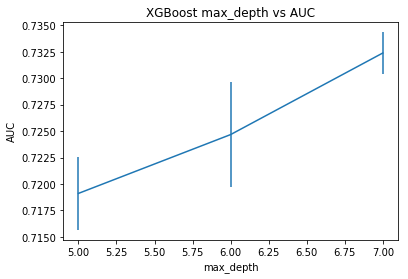

In [8]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# 
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# 
for check_param in ["max_depth"]:
    plt.errorbar(param_grid[check_param], means, yerr=stds) 
    plt.title("XGBoost {} vs AUC".format(check_param)) 
    plt.xlabel(check_param)
    plt.ylabel('AUC') 
    plt.show()

# Submission

In [9]:
X_kaggle_test = pdf_features_label.query("tvt_code == 'kaggle_test'")[ls_features]
y_test_pred = grid_search.predict_proba(X_kaggle_test)[:, 1]
y_test_pred.mean()

0.4499605

In [10]:
SK_IDs = pdf_features_label.query("tvt_code == 'kaggle_test'")["SK_ID_CURR"].tolist()
pdf_submiss = pd.DataFrame({"SK_ID_CURR": SK_IDs, "TARGET": y_test_pred})
pdf_submiss.to_csv("submissions/submission_gridsearch_{}.csv".format(version), index=False)
pdf_submiss.head()

,SK_ID_CURR,TARGET
0,100001,0.4465
1,100005,0.4508
2,100013,0.4436
3,100028,0.4465
4,100038,0.4522
